In [1]:
!git clone https://github.com/roma-vinn/CV-DL-course.git

Cloning into 'CV-DL-course'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 53 (delta 7), reused 45 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 421.59 KiB | 5.27 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [2]:
%cd /content/CV-DL-course/assignment2/

/content/CV-DL-course/assignment2


In [3]:
!bash get_datasets.sh

datasets/cifar-10-python.tar.gz: No such file or directory
tar (child): datasets/cifar-10-python.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
rm: cannot remove 'datasets/cifar-10-python.tar.gz': No such file or directory
datasets/imagenet_val_25.npz: No such file or directory


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Softmax exercise

You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [5]:
import random
import numpy as np
import zipfile

from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [7]:
%cd /content

/content


In [8]:
with zipfile.ZipFile('drive/MyDrive/cifar-10-batches-py.zip', 'r') as zip_ref:
    zip_ref.extractall()


In [11]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `utils/classifiers/softmax.py`.


$\color{Orange}{\textit Task:}$ *First implement the naive softmax loss function with nested loops. Open the file `utils/classifiers/softmax.py` and implement the `softmax_loss_naive` function. Skip the grad implementation for now.*

In [12]:
from utils.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.338752
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ With 10 classes and a random weight matrix the expected value of the softmax function for each x is equal to 0.1, which gives -log(0,1) as the expected value of the loss.



$\color{Orange}{\textit Task:}$ *Complete the implementation of `softmax_loss_naive` and implement a (naive) version of the gradient that uses nested loops.*

In [13]:
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from utils.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# Do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.337076 analytic: -0.337076, relative error: 3.566441e-08
numerical: 0.386526 analytic: 0.386525, relative error: 8.945381e-08
numerical: 0.470063 analytic: 0.470063, relative error: 1.013527e-07
numerical: -0.963024 analytic: -0.963024, relative error: 3.739973e-08
numerical: 0.745072 analytic: 0.745072, relative error: 4.804939e-08
numerical: 1.776733 analytic: 1.776733, relative error: 4.541934e-08
numerical: -1.075855 analytic: -1.075855, relative error: 5.185481e-08
numerical: 1.763114 analytic: 1.763114, relative error: 5.576418e-10
numerical: -0.926961 analytic: -0.926961, relative error: 5.741530e-08
numerical: -0.855111 analytic: -0.855111, relative error: 4.982140e-08
numerical: 0.305987 analytic: 0.305987, relative error: 8.681370e-08
numerical: 0.138547 analytic: 0.130068, relative error: 3.156560e-02
numerical: -6.313451 analytic: -6.313451, relative error: 6.806286e-09
numerical: -1.979935 analytic: -1.988023, relative error: 2.038357e-03
numerical: -0.280179

$\color{Orange}{\textit Task:}$ *Now that we have a naive implementation of the softmax loss function and its gradient, implement a vectorized version in `softmax_loss_vectorized`. The two versions should compute the same results, but the vectorized version should be much faster.*

In [14]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from utils.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# We use the Frobenius norm to compare the two versions of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.338752e+00 computed in 0.091037s
vectorized loss: 2.338752e+00 computed in 0.026549s
Loss difference: 0.000000
Gradient difference: 0.000000


$\color{Orange}{\textit Task:}$ *Use the validation set to tune hyperparameters (**regularization strength** and **learning rate**). You should experiment with different ranges for the learning rates and regularization strengths; if you are careful you should be able to get a classification accuracy of over **0.35** on the validation set.*

In [28]:
import random

from utils.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# save the best trained softmax classifer in best_softmax.                     #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [3e-7, 6e-7, 10e-7, 30e-7]
regularization_strengths = [0.5e4, 1e4, 2.5e4, 5e4, 10e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
  for rs in regularization_strengths:
    softmax = Softmax()
    softmax.train(X_train, y_train, lr, rs)
    acct = np.sum(softmax.predict(X_train) == y_train) / np.shape(X_train)[0]
    accv = np.sum(softmax.predict(X_val) == y_val) / np.shape(X_val)[0]
    results[(lr, rs)] = (acct, accv)

    if accv > best_val:
      best_val = accv
      best_softmax = softmax

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 3.000000e-07 reg 5.000000e+03 train accuracy: 0.199714 val accuracy: 0.214000
lr 3.000000e-07 reg 1.000000e+04 train accuracy: 0.200776 val accuracy: 0.191000
lr 3.000000e-07 reg 2.500000e+04 train accuracy: 0.252367 val accuracy: 0.241000
lr 3.000000e-07 reg 5.000000e+04 train accuracy: 0.295245 val accuracy: 0.312000
lr 3.000000e-07 reg 1.000000e+05 train accuracy: 0.278755 val accuracy: 0.293000
lr 6.000000e-07 reg 5.000000e+03 train accuracy: 0.234571 val accuracy: 0.247000
lr 6.000000e-07 reg 1.000000e+04 train accuracy: 0.268367 val accuracy: 0.275000
lr 6.000000e-07 reg 2.500000e+04 train accuracy: 0.324490 val accuracy: 0.344000
lr 6.000000e-07 reg 5.000000e+04 train accuracy: 0.302122 val accuracy: 0.320000
lr 6.000000e-07 reg 1.000000e+05 train accuracy: 0.287469 val accuracy: 0.300000
lr 1.000000e-06 reg 5.000000e+03 train accuracy: 0.288184 val accuracy: 0.275000
lr 1.000000e-06 reg 1.000000e+04 train accuracy: 0.322612 val accuracy: 0.324000
lr 1.000000e-06 reg 2.500000

In [29]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.341000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ True.


$\color{blue}{\textit Your Explanation:}$ SVM loss can remain the same in case newly added point has a better score for the correct class than the for the rest of the classes with a margin of at least Δ. Softmax loss will always increase because the denominator of the softmax function f(x) is always greater than the numerator (it is a sum of the numerator and some positive expression), which means L_i = -log(f(x)) > 0.



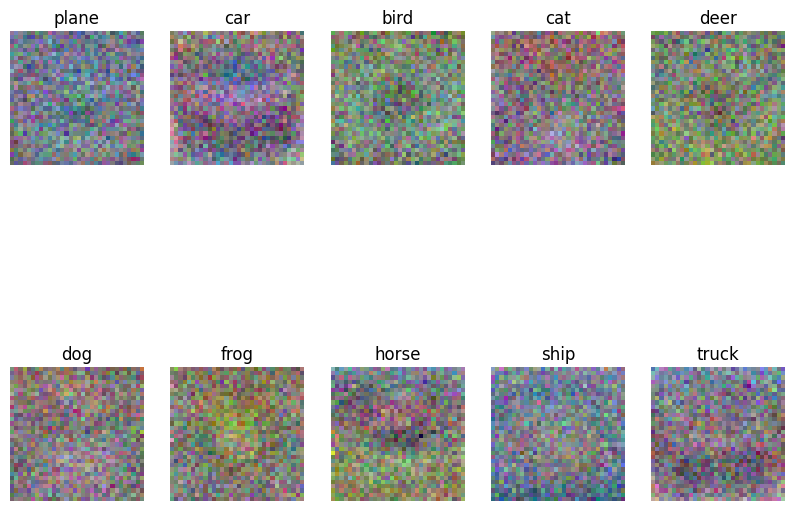

In [30]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])